In [2]:
import pymongo as pmg
import pandas as pd
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from matplotlib.lines import TICKLEFT, TICKRIGHT, Line2D
from matplotlib.patches import Rectangle
import matplotlib as mpl
import matplotlib.dates as mdate
from datetime import time
from KRData.HKData import HKFuture
import talib as tb
import configparser
from kline import Kline

conf_parser = configparser.ConfigParser()
conf_parser.read( 'conf.ini')
mg_host = conf_parser.get('MGDB', 'host')
mg_user = conf_parser.get('MGDB', 'user')
mg_password = conf_parser.get('MGDB', 'password')
hf=HKFuture(pwd=mg_password,host=mg_host,user=mg_user)
begin='2011-01-01'
dt1=dt.datetime.now()
_fields = ['datetime', 'code', 'open', 'high', 'low', 'close', 'vol','trade_date']
df=hf.get_bars('HSI1201',_fields)
df.head()

,datetime,code,open,high,low,close,trade_date
datetime,,,,,,,
2011-11-30 09:15:00,2011-11-30 09:15:00,HSI1201,18157.0,18157.0,18113.0,18113.0,2011-11-30
2011-11-30 09:17:00,2011-11-30 09:17:00,HSI1201,18131.0,18131.0,18130.0,18130.0,2011-11-30
2011-11-30 09:19:00,2011-11-30 09:19:00,HSI1201,18140.0,18140.0,18140.0,18140.0,2011-11-30
2011-11-30 09:21:00,2011-11-30 09:21:00,HSI1201,18127.0,18127.0,18115.0,18115.0,2011-11-30
2011-11-30 09:28:00,2011-11-30 09:28:00,HSI1201,18107.0,18107.0,18107.0,18107.0,2011-11-30


In [73]:
from bt_base import backtesting as bt

class bt_macd(bt):
    #测试参数-----------------------------------------------------------------------
    def trade_para(self):
        self.Stop_Diff=60
        
    def trade_main(self):
        if self._para['trade_p']['trade_state']==0:
            self.trade_open()
        if self._para['trade_p']['trade_state']==1:
            self.trade_stop()
            
    def trade_init(self):
        self._para['trade']={}
        self._para['trade_p']={}
        self._para['trade_p']['trade_state']=0
        
    def trade_open(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        macd=self._para['macd']
        row=self._para['row']
        cont=macd['ma60_no']>0 and macd['no']==1
        cont1=macd['state']=='green' and macd['ma60_state']=='over'
        cont2=macd['state']=='red' and macd['ma60_state']=='under'
        if all([cont,cont1 or cont2]):
            trade['open']=row['close']
            trade['date']=self._para['date']
            trade['open_idx']=self._para['day_no']
            trade['ma60_no']=macd['ma60_no']
            if cont1:
                trade['state']='buy'
                trade['stop_price']=row['open']-self.Stop_Diff
            else:
                trade['state']='sell'
                trade['stop_price']=row['open']+self.Stop_Diff
            trade_p['trade_state']=1
            trade['macd_state']=macd['state']
        
        self._para['trade']=trade
        self._para['trade_p']=trade_p
    
    def trade_stop(self):
        trade=self._para['trade']
        trade_p=self._para['trade_p']
        ma60=self._para['ma60']
        macd=self._para['macd']
        row=self._para['row']
#         if (row['close']-self.Stop_Diff)>trade['stop_price'] and trade['state']=='buy':
#             trade['stop_price']=row['close']-self.Stop_Diff
#         elif (row['close']+self.Stop_Diff)<trade['stop_price'] and trade['state']=='sell':
#             trade['stop_price']=row['close']+self.Stop_Diff
            
        cont1=row['close']<trade['stop_price'] and trade['state']=='buy'
        cont2=row['close']>trade['stop_price'] and trade['state']=='sell'
        cont3=macd['state']!=trade['macd_state']
        
        if any([cont1,cont2,cont3]):
            trade['close']=row['close']
            trade['close_type']='macd' if cont3 else 'stop'
            trade['close_idx']=self._para['day_no']
            trade['diff']=trade['close']-trade['open'] if trade['state']=='buy' \
                                            else trade['open']-trade['close']
            trade['prod']=self._para['prod']
            self._res['trade'].append(trade)
            trade_p['trade_state']=0
            self._para['trade']={}
            
    #每日交易结束----------------------------------------------------------------------------------
    def trade_end(self):
        if self._para['trade_p']['trade_state']==0:
            return
        trade=self._para['trade']
        row=self._para['row']
        if self._para['trade_p']['trade_state']==1:
            trade['close']=row['open']
            trade['close_type']='end'
            trade['close_idx']=self._para['day_no']
            
        trade['diff']=trade['close']-trade['open'] if trade['state']=='buy' \
                                            else trade['open']-trade['close']
        trade['prod']=self._para['prod']
        self._res['trade'].append(trade)
        
print("OK")

OK


In [23]:
def GetROI(F1):
    Res={}
    Res['ALL_Profit'],Res['All_CNT'],Res['All_Mean']=F1['diff'].agg(['sum','count','mean'])
    Res['Win_Sum'],Res['Win_CNT'],Res['Win_Mean'],Res['Win_Max'],Res['Win_Min']= \
        F1[F1['diff']>0]['diff'].agg(['sum','count','mean','max','min'])
    Res['Lose_Sum'],Res['Lose_CNT'],Res['Lose_Mean'],Res['Lose_Max'],Res['Lose_Min']=\
        F1[F1['diff']<0]['diff'].agg(['sum','count','mean','max','min'])
    Res['Win/Lose']=Res['Win_Mean']/-Res['Lose_Mean']
    Res['Win%']=Res['Win_CNT']*100/Res['All_CNT']
    Res['ROI']=Res['Win/Lose']*Res['Win%']-50.0
    return Res

In [74]:
time1=dt.datetime.now()
print(time1)
bt2=bt_macd(hf)
# bt2.prod_test('HSI1109')
bt2.Stop_Diff=150
bt2.prod_all()
time2=dt.datetime.now()
print(time2-time1)
df1=pd.DataFrame(bt2._res['trade'])
df1.head()

2019-06-01 19:34:51.619602
0:02:32.573698


,close,close_idx,close_type,date,diff,ma60_no,macd_state,open,open_idx,prod,state,stop_price
0,23416.0,99,macd,2011-01-03,34.0,1,green,23382.0,95,HSI1101,buy,23238.0
1,23392.0,246,macd,2011-01-03,-27.0,5,green,23419.0,223,HSI1101,buy,23273.0
2,23398.0,265,macd,2011-01-03,6.0,5,red,23404.0,247,HSI1101,sell,23542.0
3,23539.0,53,macd,2011-01-04,15.0,3,green,23524.0,52,HSI1101,buy,23378.0
4,23517.0,73,macd,2011-01-04,4.0,4,green,23513.0,71,HSI1101,buy,23364.0


In [72]:
# df1=pd.DataFrame(bt2._res['trade'])
GetROI(df1)

{'ALL_Profit': 11112.0,
 'All_CNT': 10611.0,
 'All_Mean': 1.0472151540853831,
 'Win_Sum': 106227.0,
 'Win_CNT': 7535.0,
 'Win_Mean': 14.097810218978102,
 'Win_Max': 310.0,
 'Win_Min': 1.0,
 'Lose_Sum': -95115.0,
 'Lose_CNT': 2905.0,
 'Lose_Mean': -32.741824440619624,
 'Lose_Max': -1.0,
 'Lose_Min': -250.0,
 'Win/Lose': 0.4305749743587382,
 'Win%': 71.01121477711808,
 'ROI': -19.42434801815953}

In [75]:
GetROI(df1)

{'ALL_Profit': 11797.0,
 'All_CNT': 10593.0,
 'All_Mean': 1.1136599641272538,
 'Win_Sum': 105827.0,
 'Win_CNT': 7526.0,
 'Win_Mean': 14.0615200637789,
 'Win_Max': 310.0,
 'Win_Min': 1.0,
 'Lose_Sum': -94030.0,
 'Lose_CNT': 2896.0,
 'Lose_Mean': -32.4689226519337,
 'Lose_Max': -1.0,
 'Lose_Min': -250.0,
 'Win/Lose': 0.4330762746432383,
 'Win%': 71.04691777588974,
 'ROI': -19.231265524733207}

In [63]:
Calc=['sum','count','mean','max','min']
df1.groupby(['macd_state','ma60_no'])['diff'].agg(Calc)

sum  count       mean    max    min
macd_state ma60_no                                        
green      1       -1221.0    440  -2.775000   84.0 -395.0
           2        1078.0    447   2.411633  229.0 -217.0
           3        1182.0    434   2.723502   85.0 -172.0
           4        1302.0    423   3.078014  310.0 -384.0
           5        1148.0    355   3.233803   58.0 -132.0
           6         649.0    350   1.854286   75.0 -192.0
           7         273.0    341   0.800587   67.0 -409.0
           8         240.0    325   0.738462   84.0 -367.0
           9         442.0    321   1.376947   64.0 -164.0
           10        258.0    283   0.911661   47.0 -207.0
           11        484.0    258   1.875969   89.0 -195.0
           12         96.0    223   0.430493   55.0 -169.0
           13        -97.0    188  -0.515957   45.0 -102.0
           14        379.0    155   2.445161   47.0 -143.0
           15         17.0    167   0.101796   53.0 -168.0
           16          7.0    113   0.061947   38.0  -94.0
           17        231.0     95   2.431579   44.0  -92.0
           18        247.0     74   3.337838   30.0  -67.0
           19       -287.0     57  -5.035088   23.0 -120.0
           20        -37.0     35  -1.057143   32.0 -136.0
           21       -131.0     30  -4.366667   18.0 -105.0
           22         55.0     26   2.115385   24.0  -49.0
           23         -6.0     17  -0.352941   17.0  -77.0
           24       -172.0      8 -21.500000   17.0 -185.0
           25          2.0      9   0.222222   13.0  -18.0
           26          9.0      4   2.250000   19.0   -9.0
           27         29.0      2  14.500000   20.0    9.0
           28          3.0      1   3.000000    3.0    3.0
           30          2.0      1   2.000000    2.0    2.0
red        1         178.0    410   0.434146  156.0 -425.0
           2       -1974.0    417  -4.733813  148.0 -882.0
           3         953.0    371   2.568733   77.0 -352.0
           4         798.0    416   1.918269   74.0 -439.0
           5        1416.0    367   3.858311   73.0 -213.0
           6         994.0    376   2.643617   82.0 -195.0
           7         868.0    370   2.345946   50.0 -309.0
           8         938.0    346   2.710983   72.0 -148.0
           9         146.0    295   0.494915   47.0 -336.0
           10        912.0    280   3.257143   55.0 -158.0
           11       -285.0    260  -1.096154   59.0 -365.0
           12        348.0    223   1.560538   39.0 -256.0
           13        148.0    228   0.649123   83.0 -498.0
           14        291.0    169   1.721893   65.0 -110.0
           15        231.0    167   1.383234   51.0  -98.0
           16       -439.0    132  -3.325758   45.0 -217.0
           17        163.0     84   1.940476   40.0 -138.0
           18        174.0     85   2.047059   40.0 -116.0
           19       -581.0     74  -7.851351   30.0 -245.0
           20         -4.0     31  -0.129032   22.0 -108.0
           21         22.0     30   0.733333   28.0  -23.0
           22        143.0     26   5.500000   68.0  -45.0
           23        -83.0     22  -3.772727   24.0  -55.0
           24         24.0     10   2.400000   19.0  -54.0
           25        -59.0      7  -8.428571   11.0  -50.0
           26         -2.0      3  -0.666667    9.0  -17.0
           27        -17.0      3  -5.666667   12.0  -16.0
           28          5.0      1   5.000000    5.0    5.0
           30         -8.0      1  -8.000000   -8.0   -8.0
           32        -20.0      1 -20.000000  -20.0  -20.0

In [76]:
#循环测试某个参数
Calc=['sum','count','mean','std','max','min']
time1=dt.datetime.now()
print(time1)
TestAll={}
df={}
for i in range(20,200,10):
    print(i)
    test=bt_macd(hf,index='HSI')
    test.Stop_Diff=i
    test.prod_all()
#     test.prod_test('HSI1903')
    df[i]=pd.DataFrame(test._res['trade'])
    TestAll[i]=GetROI(df[i])
time2=dt.datetime.now()
print(time2-time1)
pd.DataFrame(TestAll).T

2019-06-01 19:38:31.940770
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
0:45:55.692352


,ALL_Profit,All_CNT,All_Mean,Lose_CNT,Lose_Max,Lose_Mean,Lose_Min,Lose_Sum,ROI,Win%,Win/Lose,Win_CNT,Win_Max,Win_Mean,Win_Min,Win_Sum
20,7976.0,17272.0,0.461788,6756.0,-1.0,-22.963144,-250.0,-155139.0,-8.873673,55.726031,0.738009,9625.0,331.0,16.947013,1.0,163115.0
30,9433.0,14656.0,0.643627,5047.0,-1.0,-28.011294,-250.0,-141373.0,-13.265850,62.745633,0.585446,9196.0,331.0,16.399087,1.0,150806.0
40,9377.0,13223.0,0.709143,4161.0,-1.0,-31.361452,-250.0,-130495.0,-16.270909,66.376768,0.508146,8777.0,331.0,15.936197,1.0,139872.0
50,10900.0,12351.0,0.882520,3705.0,-1.0,-32.556005,-250.0,-120620.0,-17.291655,68.188811,0.479673,8422.0,345.0,15.616243,1.0,131520.0
60,10678.0,11831.0,0.902544,3444.0,-1.0,-33.357724,-250.0,-114884.0,-18.184382,69.241822,0.459486,8192.0,193.0,15.327393,1.0,125562.0
70,11585.0,11465.0,1.010467,3277.0,-1.0,-33.078731,-250.0,-108399.0,-18.362625,69.751417,0.453573,7997.0,310.0,15.003626,1.0,119984.0
80,12028.0,11204.0,1.073545,3157.0,-1.0,-32.992715,-250.0,-104158.0,-18.568678,70.180293,0.447865,7863.0,310.0,14.776294,1.0,116186.0
90,11624.0,11040.0,1.052899,3073.0,-1.0,-33.161080,-250.0,-101904.0,-18.989752,70.498188,0.439873,7783.0,310.0,14.586663,1.0,113528.0
100,11094.0,10906.0,1.017238,3032.0,-1.0,-32.930409,-250.0,-99845.0,-19.109735,70.575830,0.437689,7697.0,310.0,14.413278,1.0,110939.0
110,11352.0,10819.0,1.049265,2988.0,-1.0,-33.088019,-250.0,-98867.0,-19.210787,70.755153,0.435152,7655.0,310.0,14.398302,1.0,110219.0


In [34]:
def drawKK(k,prod,date,**para):
    t1=dt.time(9,15,0)
    t2=dt.time(16,30,0)
    # a2=aa[aa.datetime.apply(lambda x:t1<=x.time()<=t2)]
    rec_end=66
    test1=bt(hf)
    # prod='HSI1103'
    test1.prod_init(prod)
    aa=test1._para['df_prod']
    a2=aa[aa.datetime.apply(lambda x:t1<=x.time()<=t2)]
    # date='2011-02-28'
    k.DrawKline(a2[a2.trade_date==date],rec=(7,66),**para)

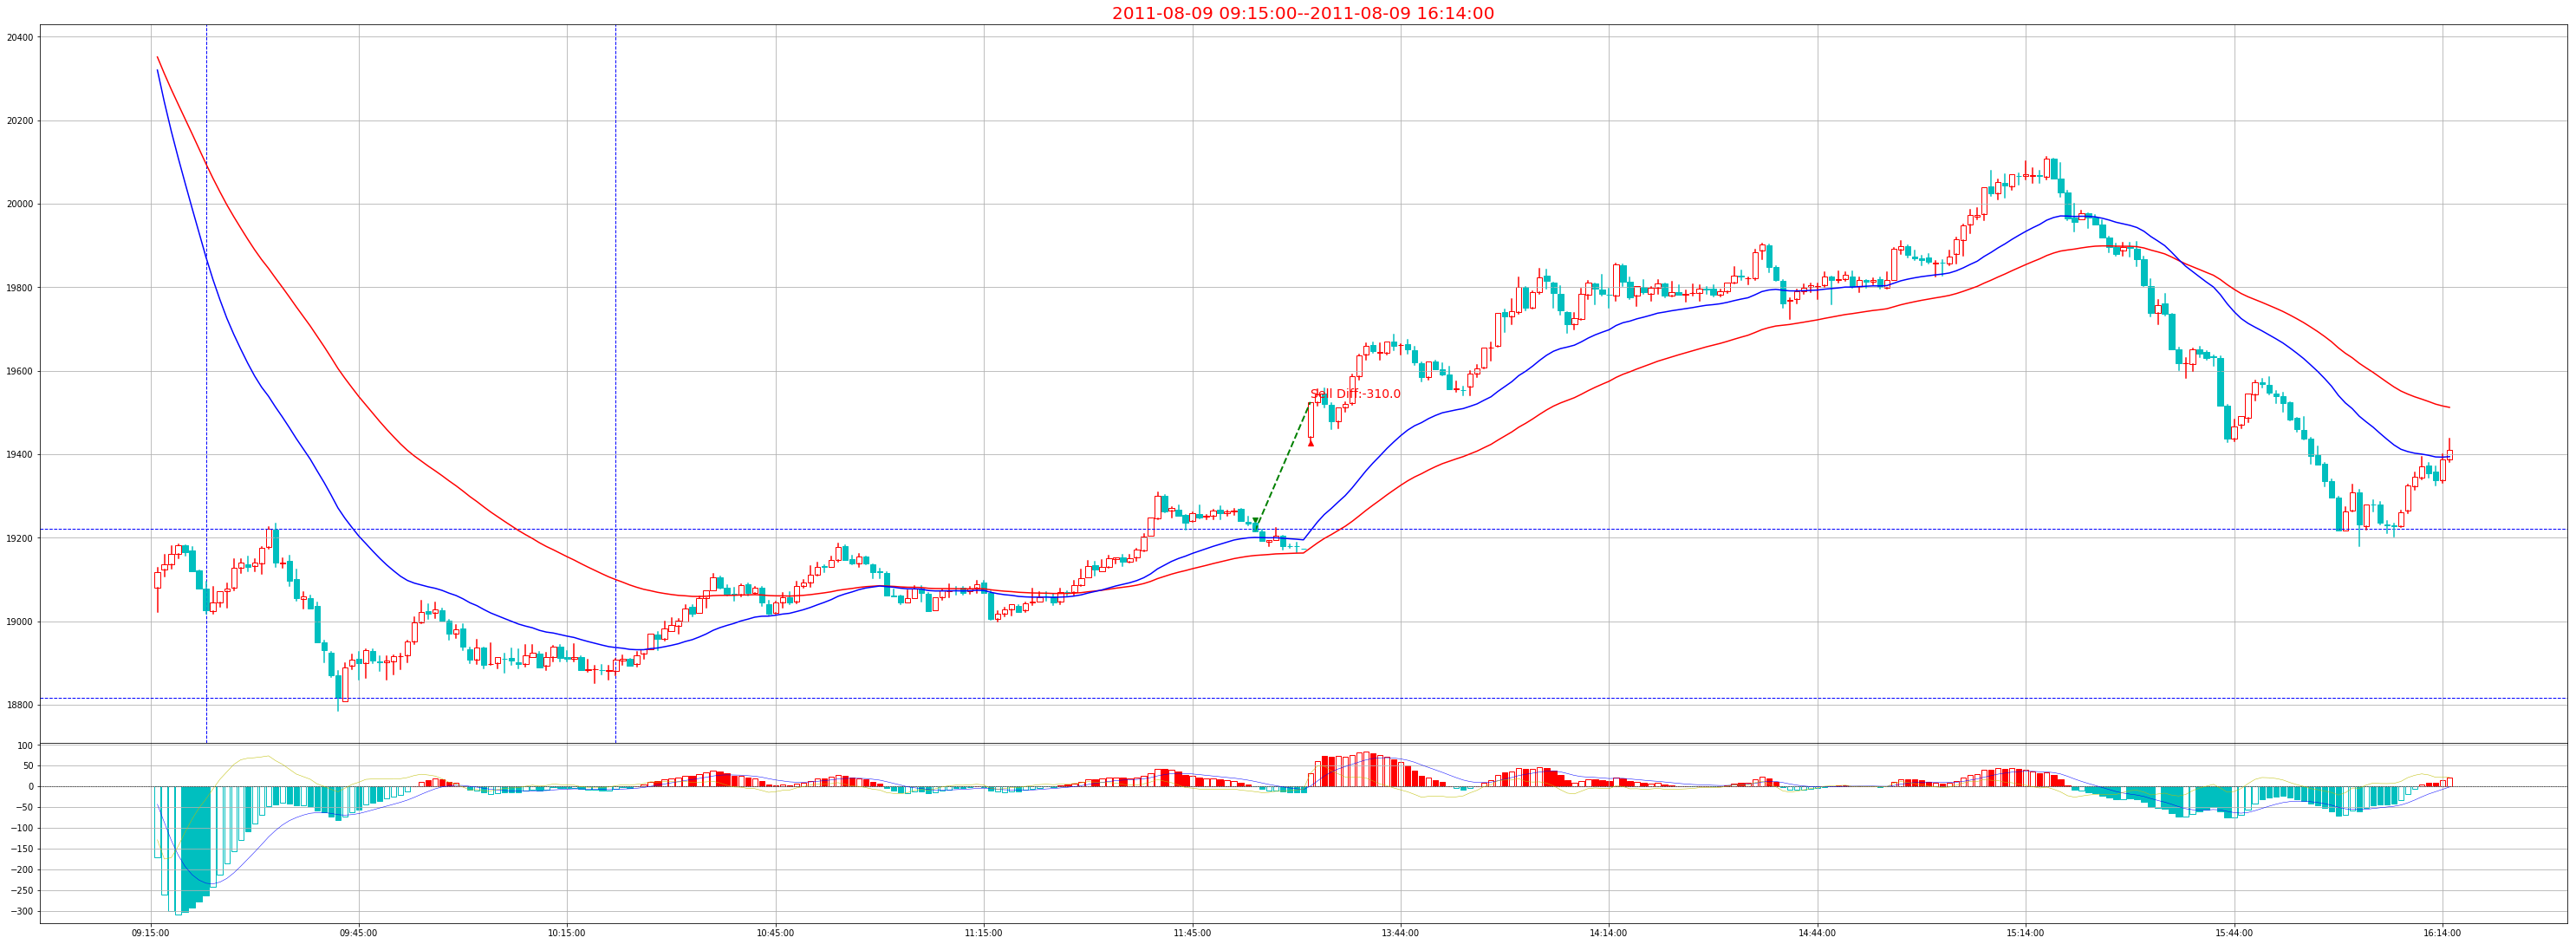

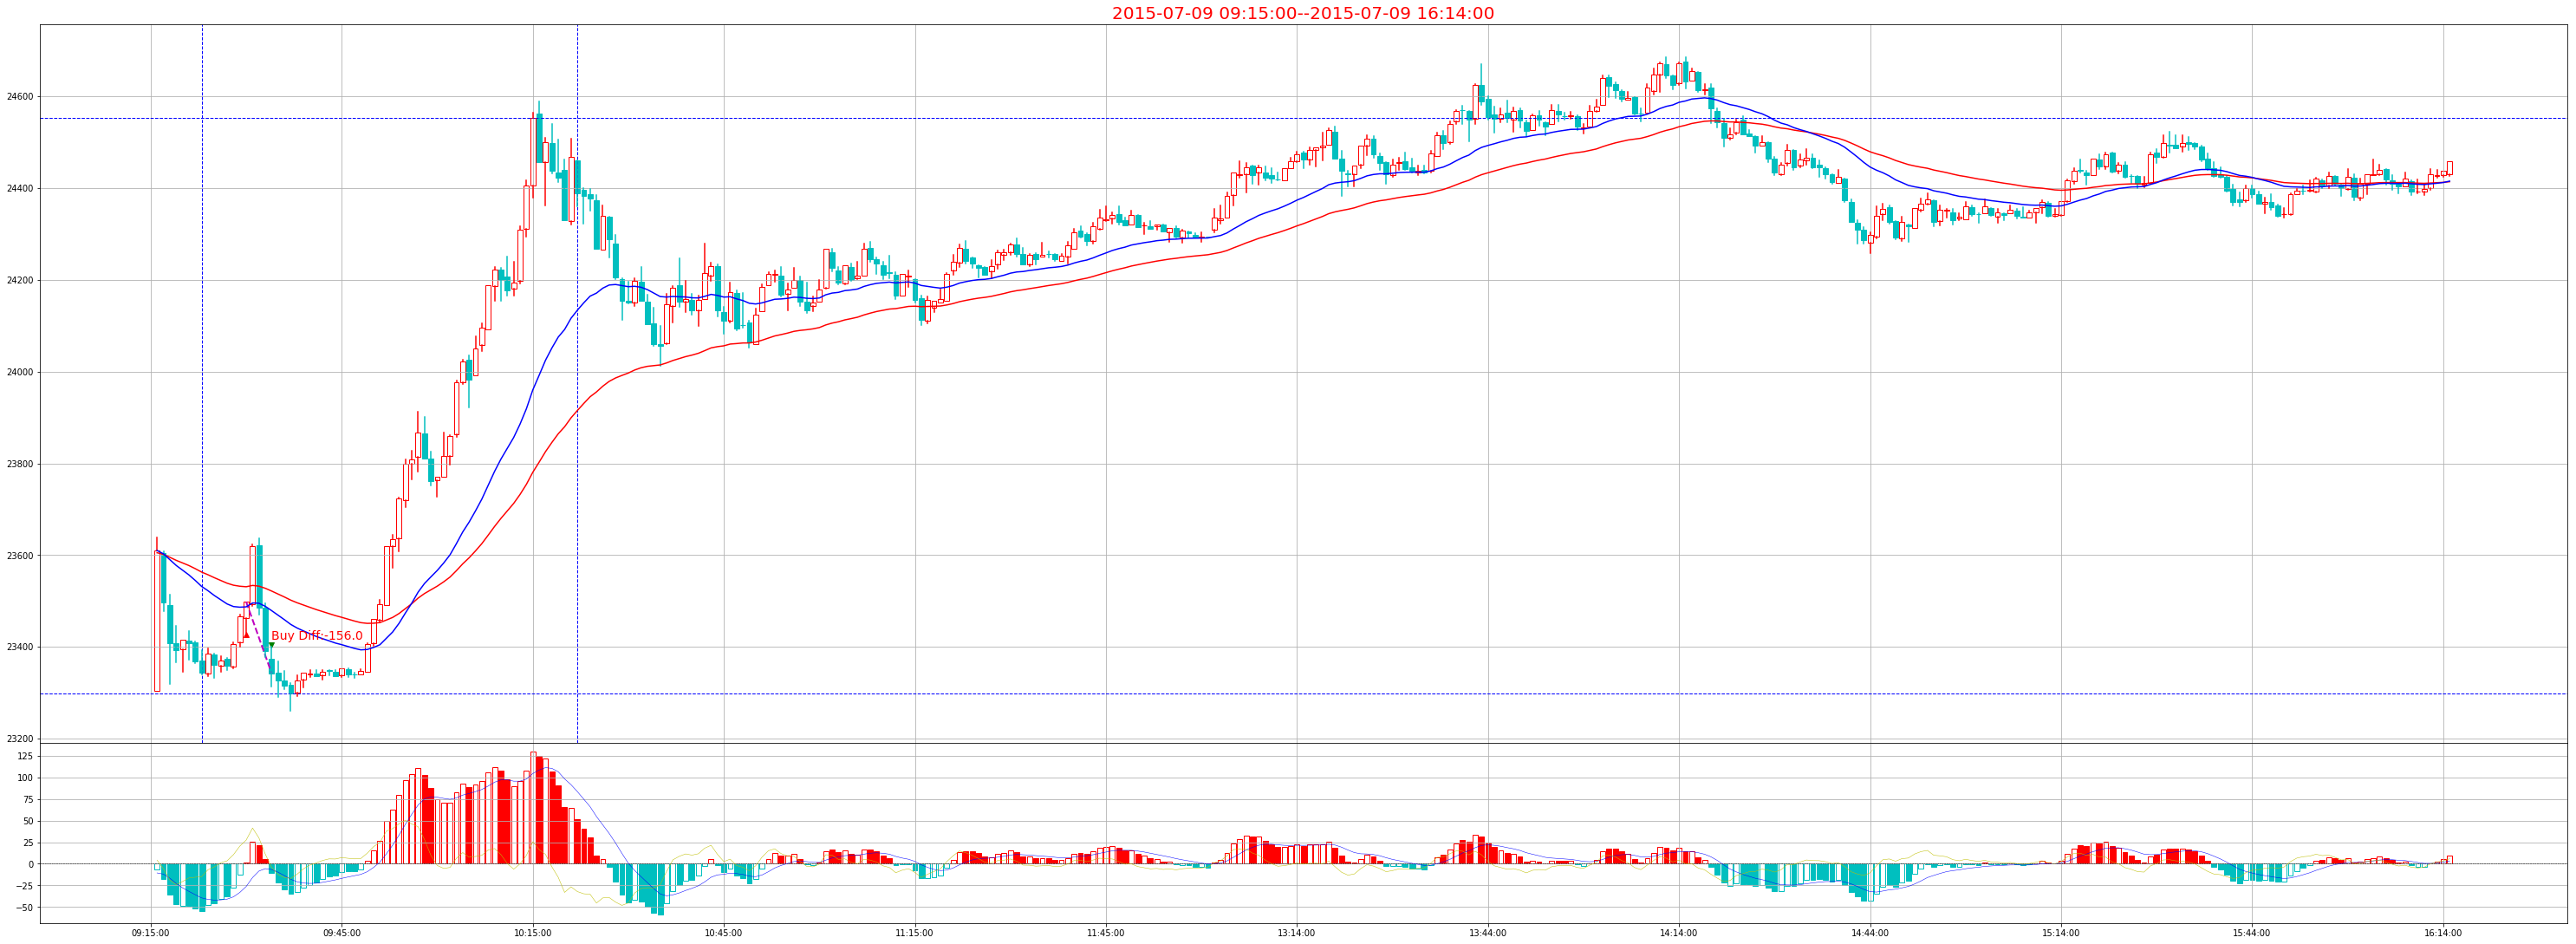

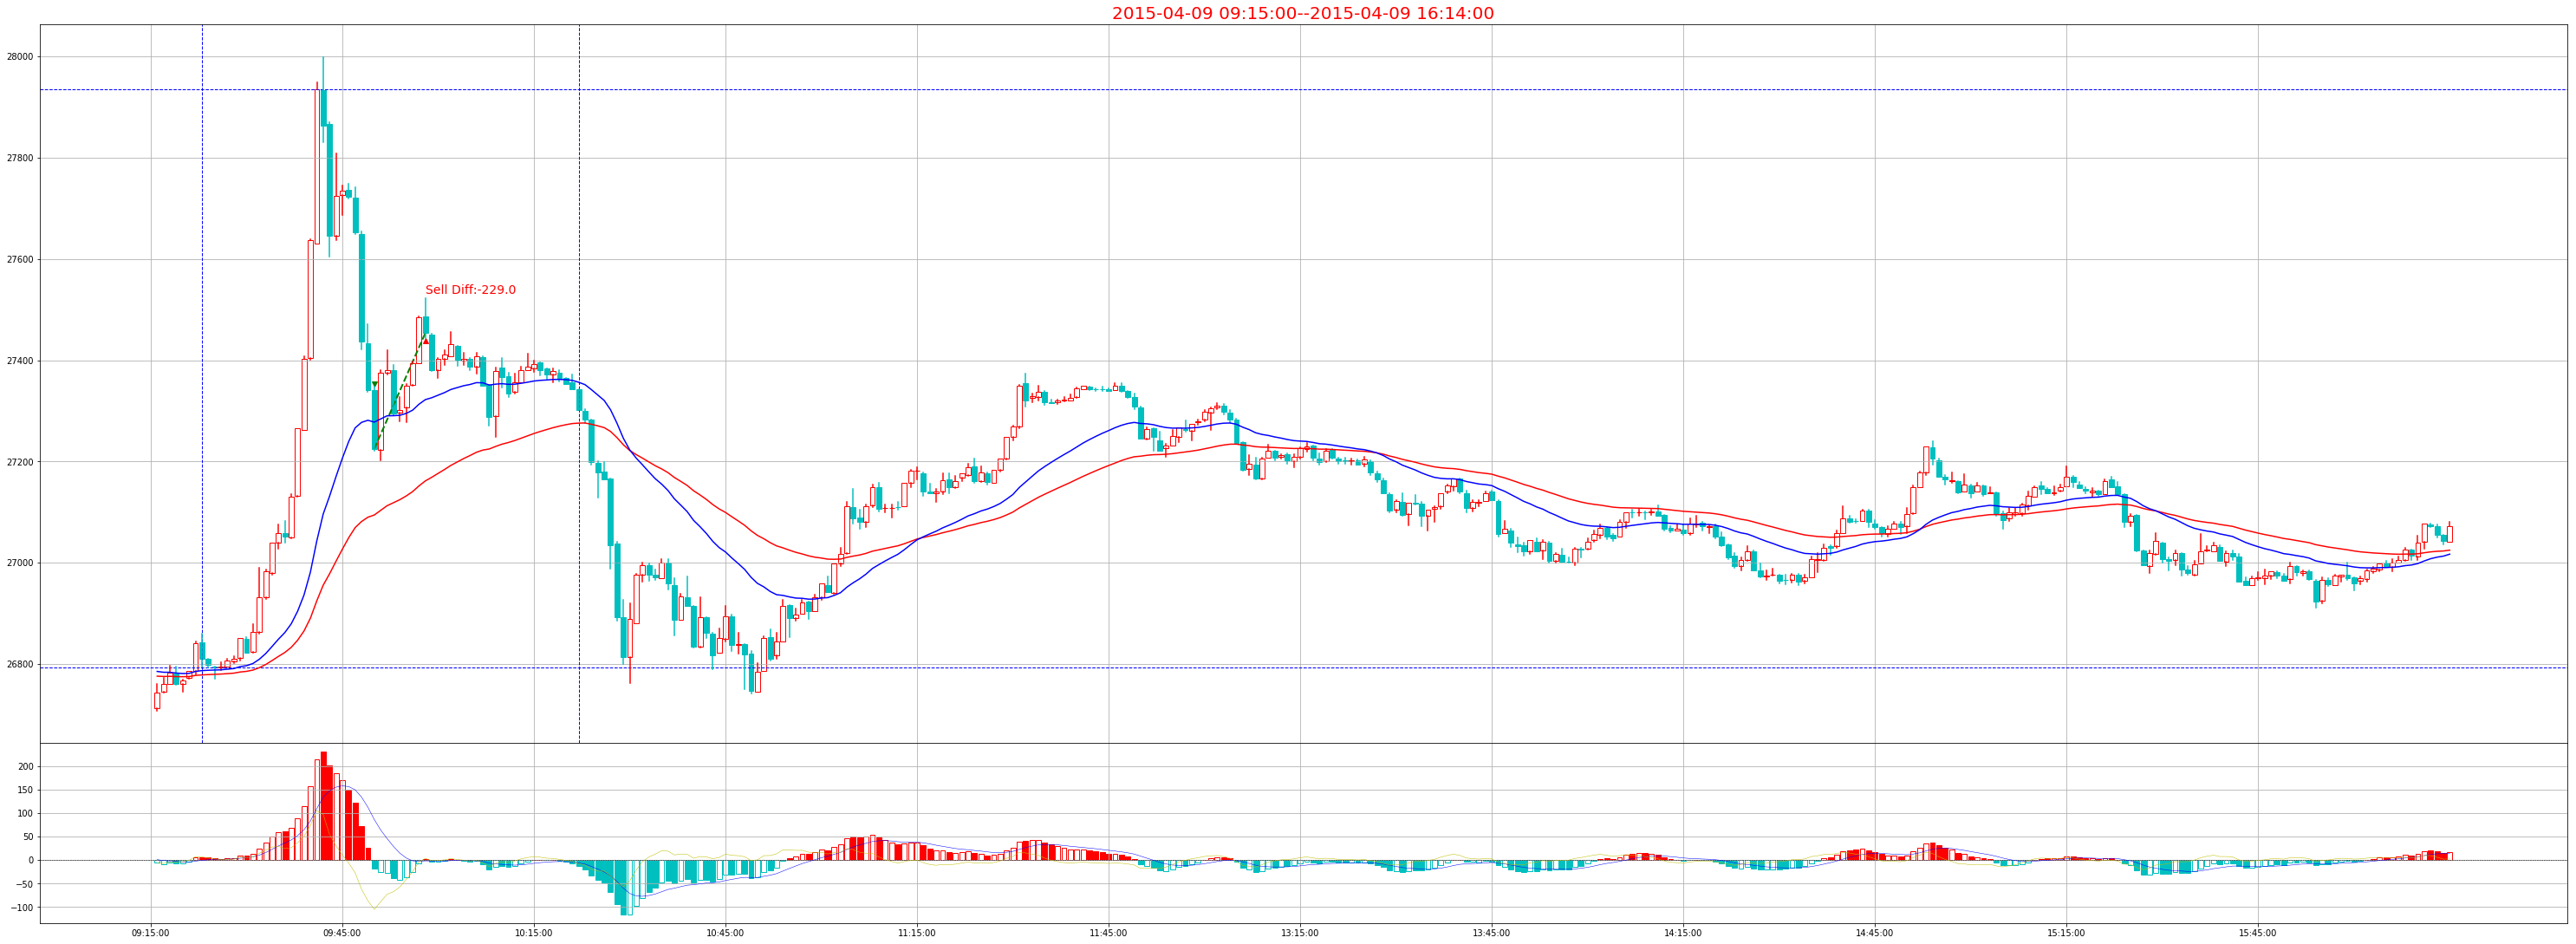

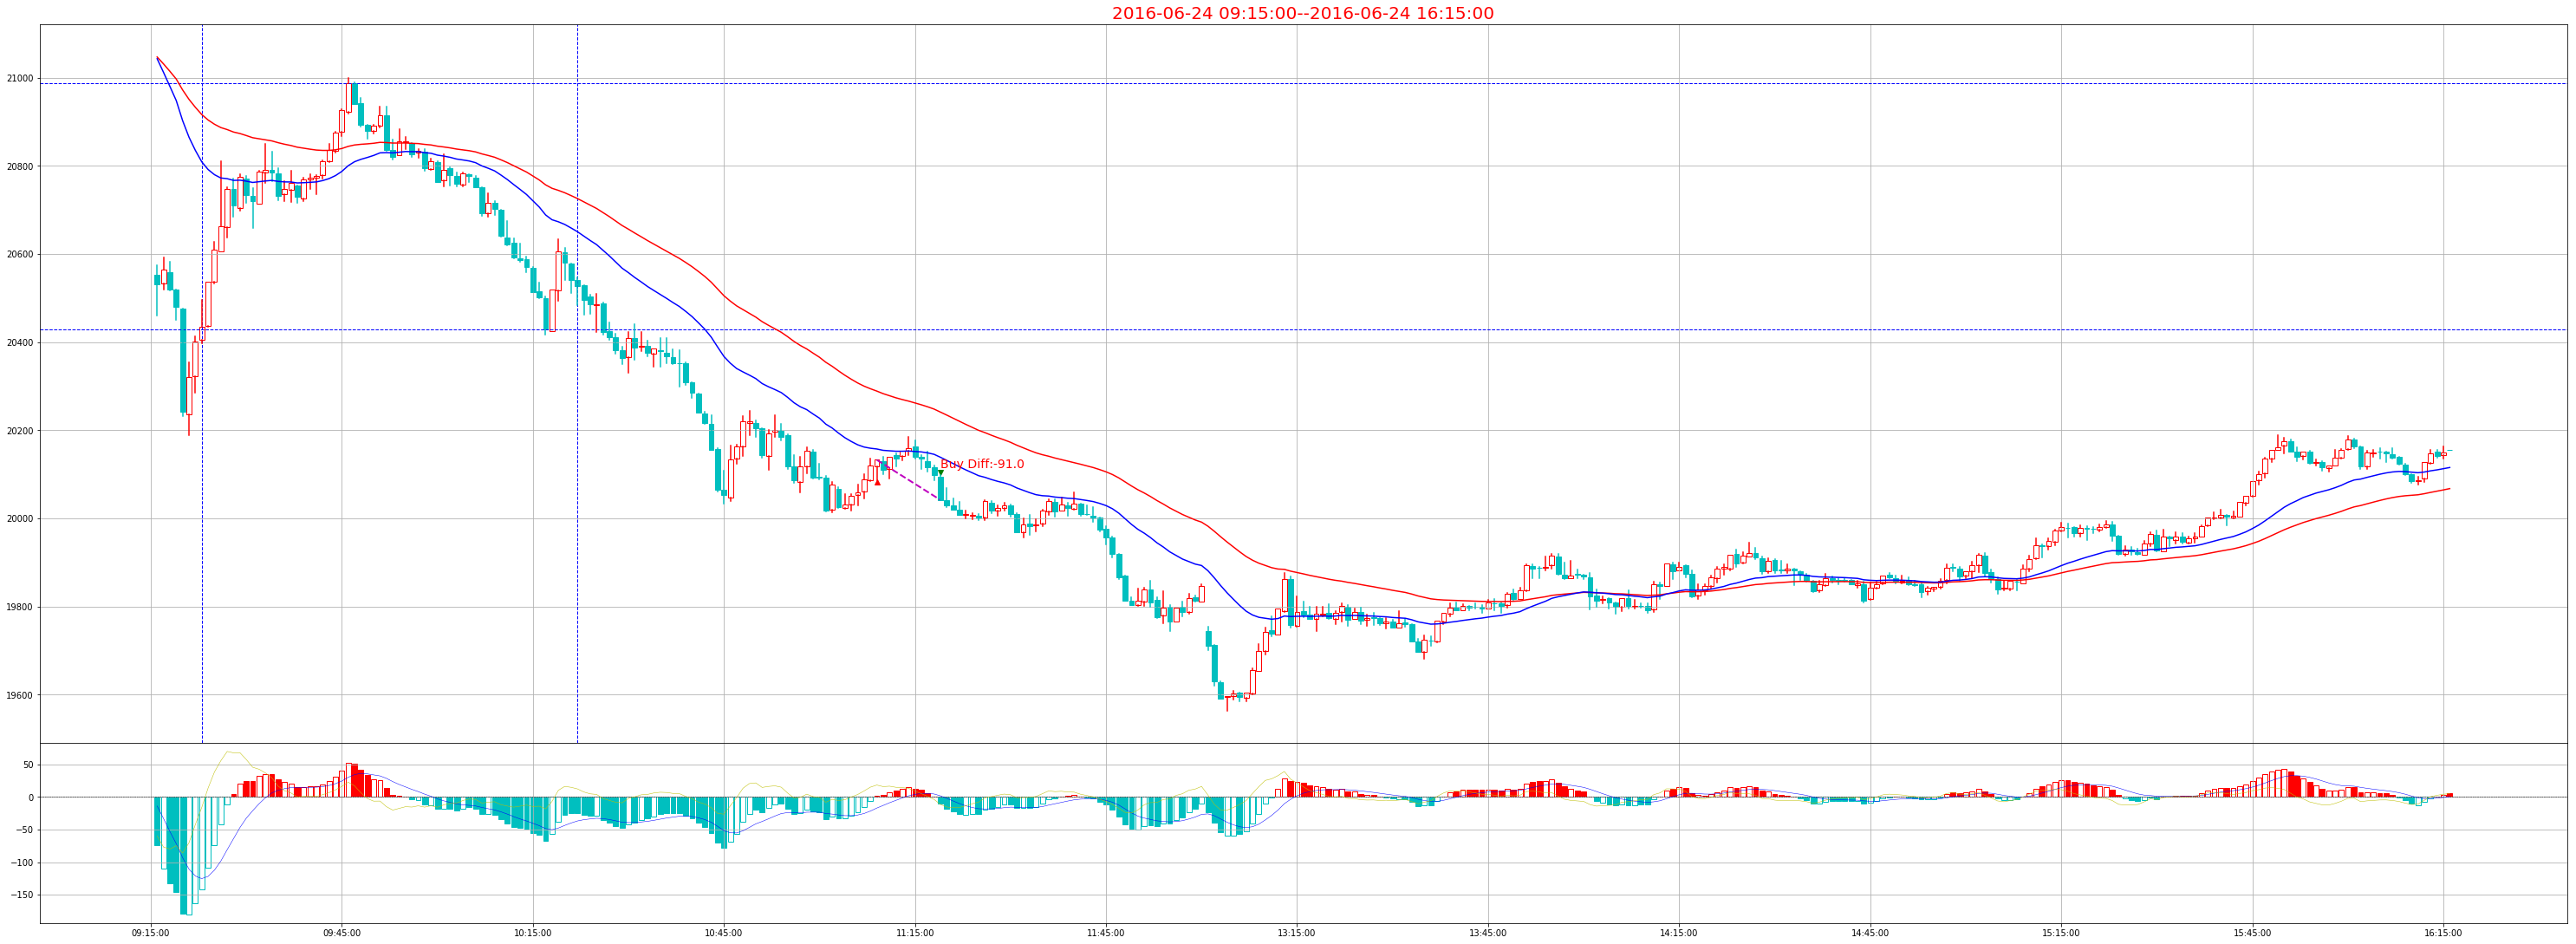

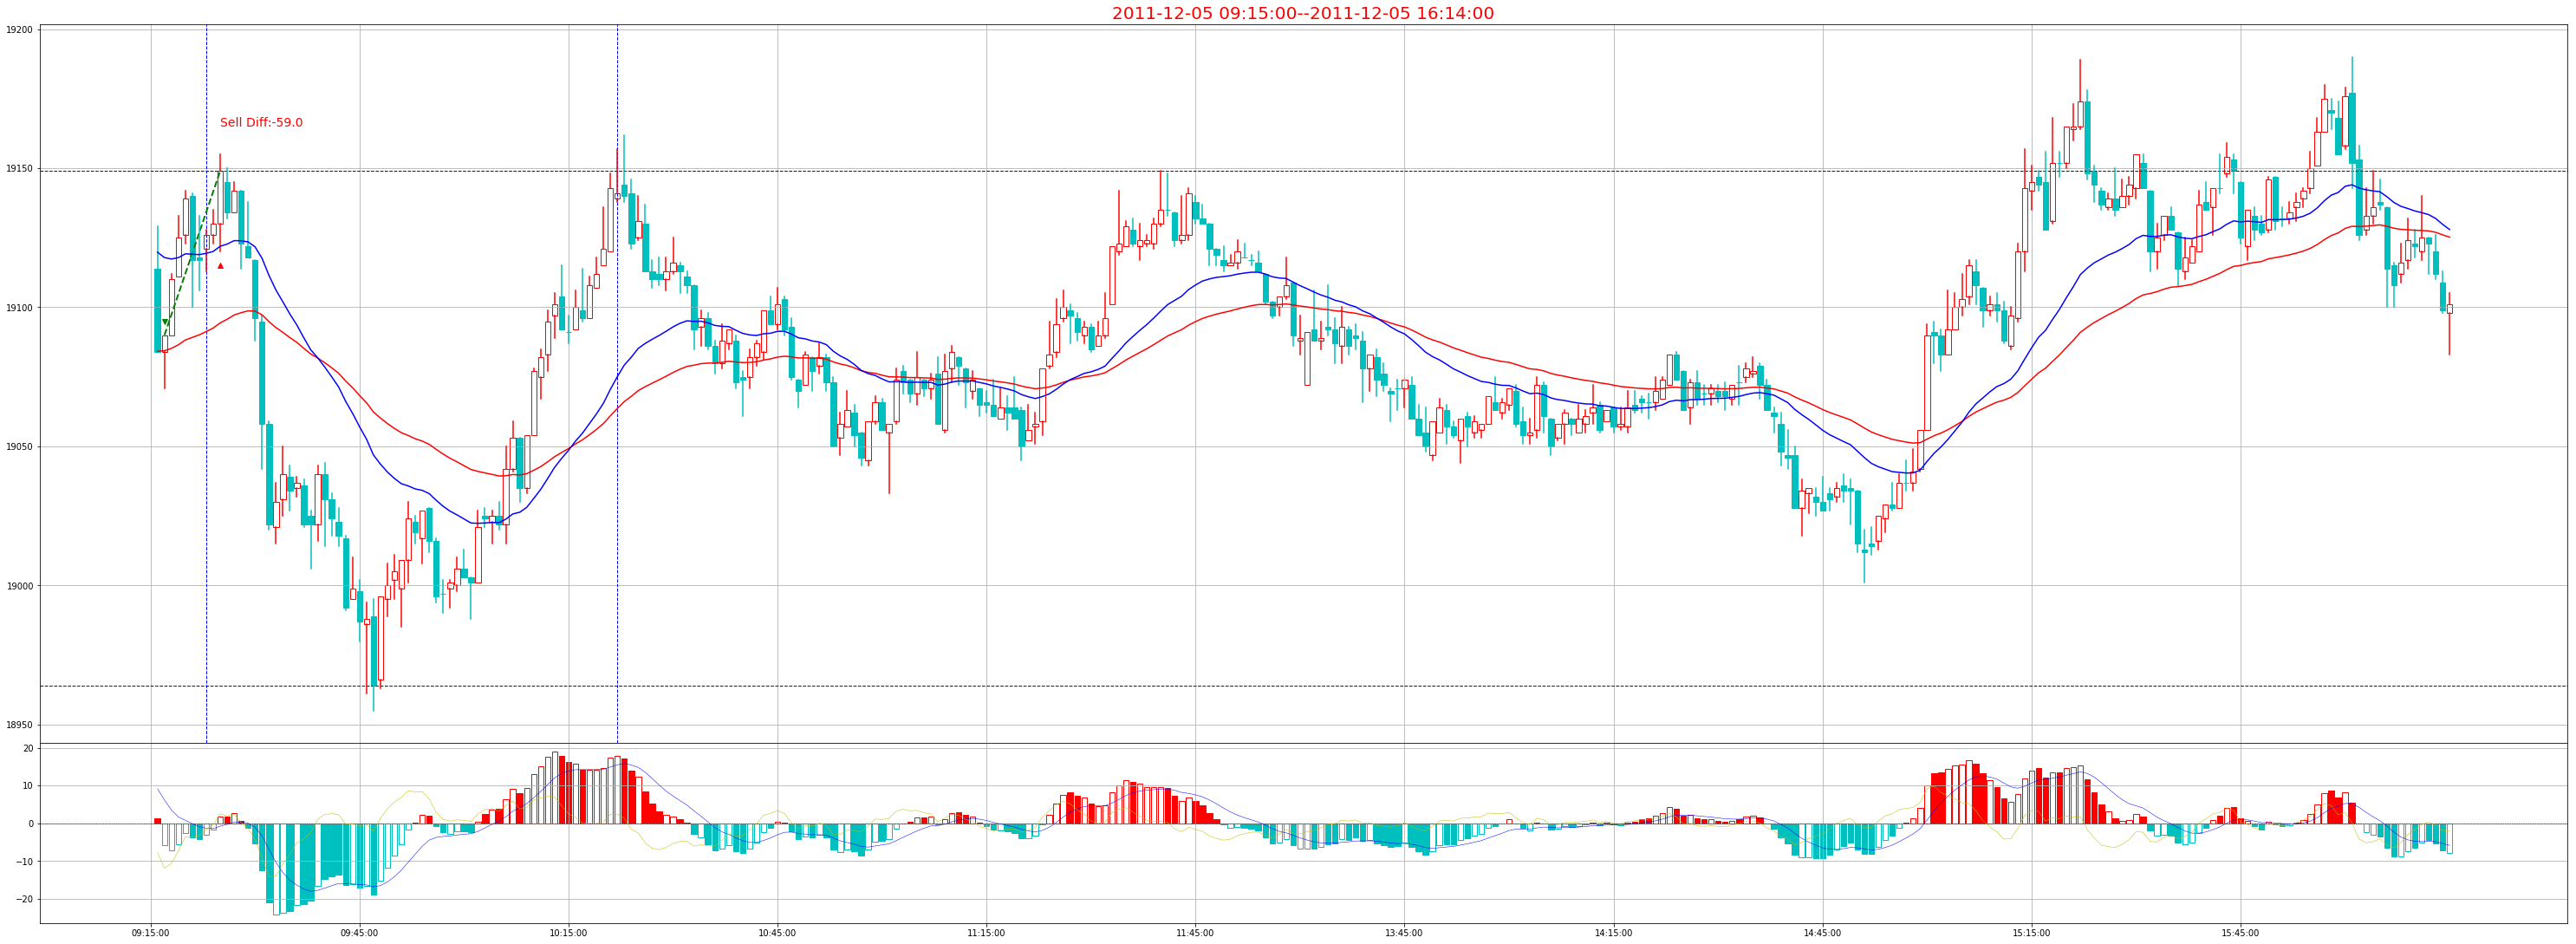

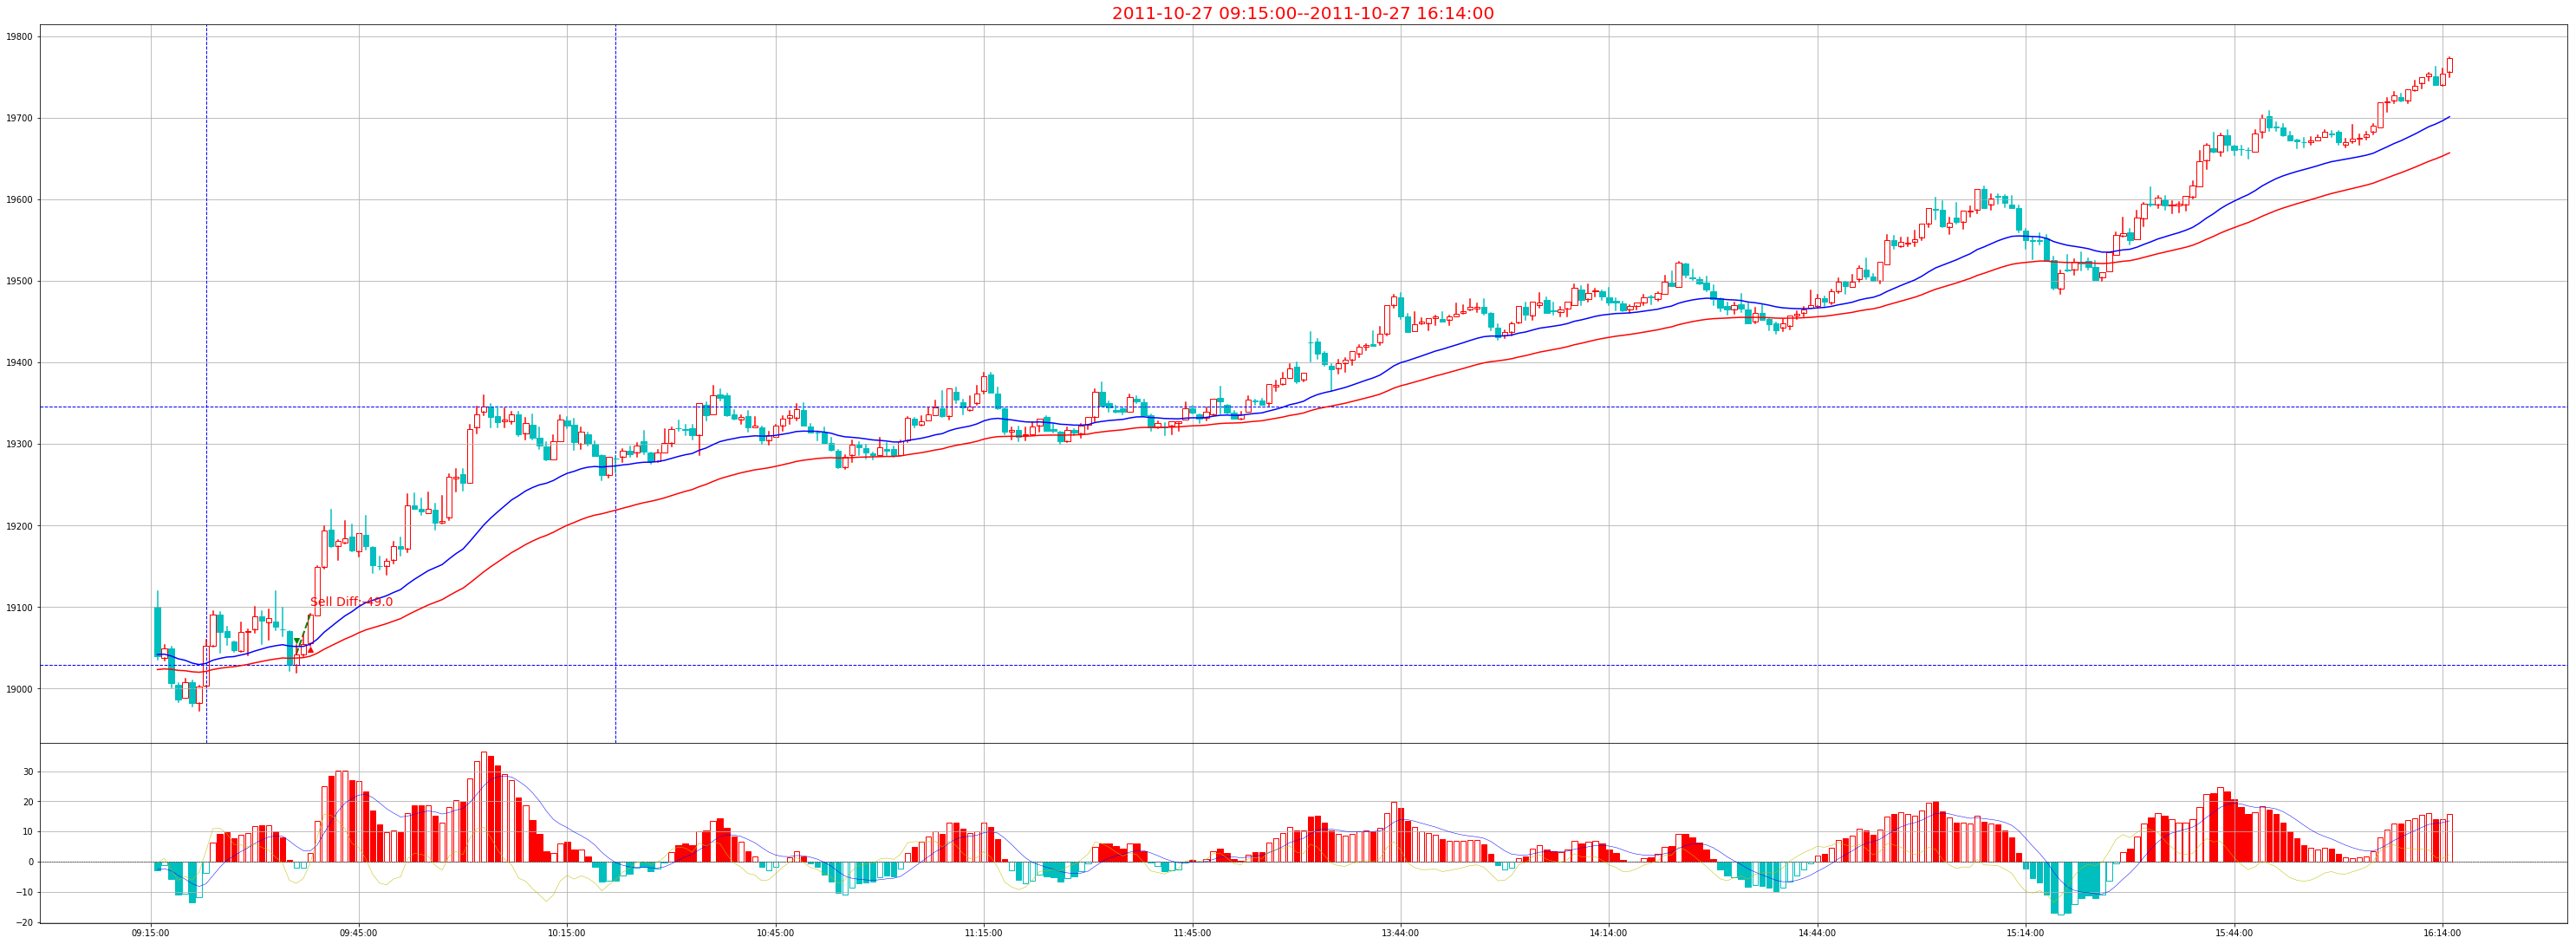

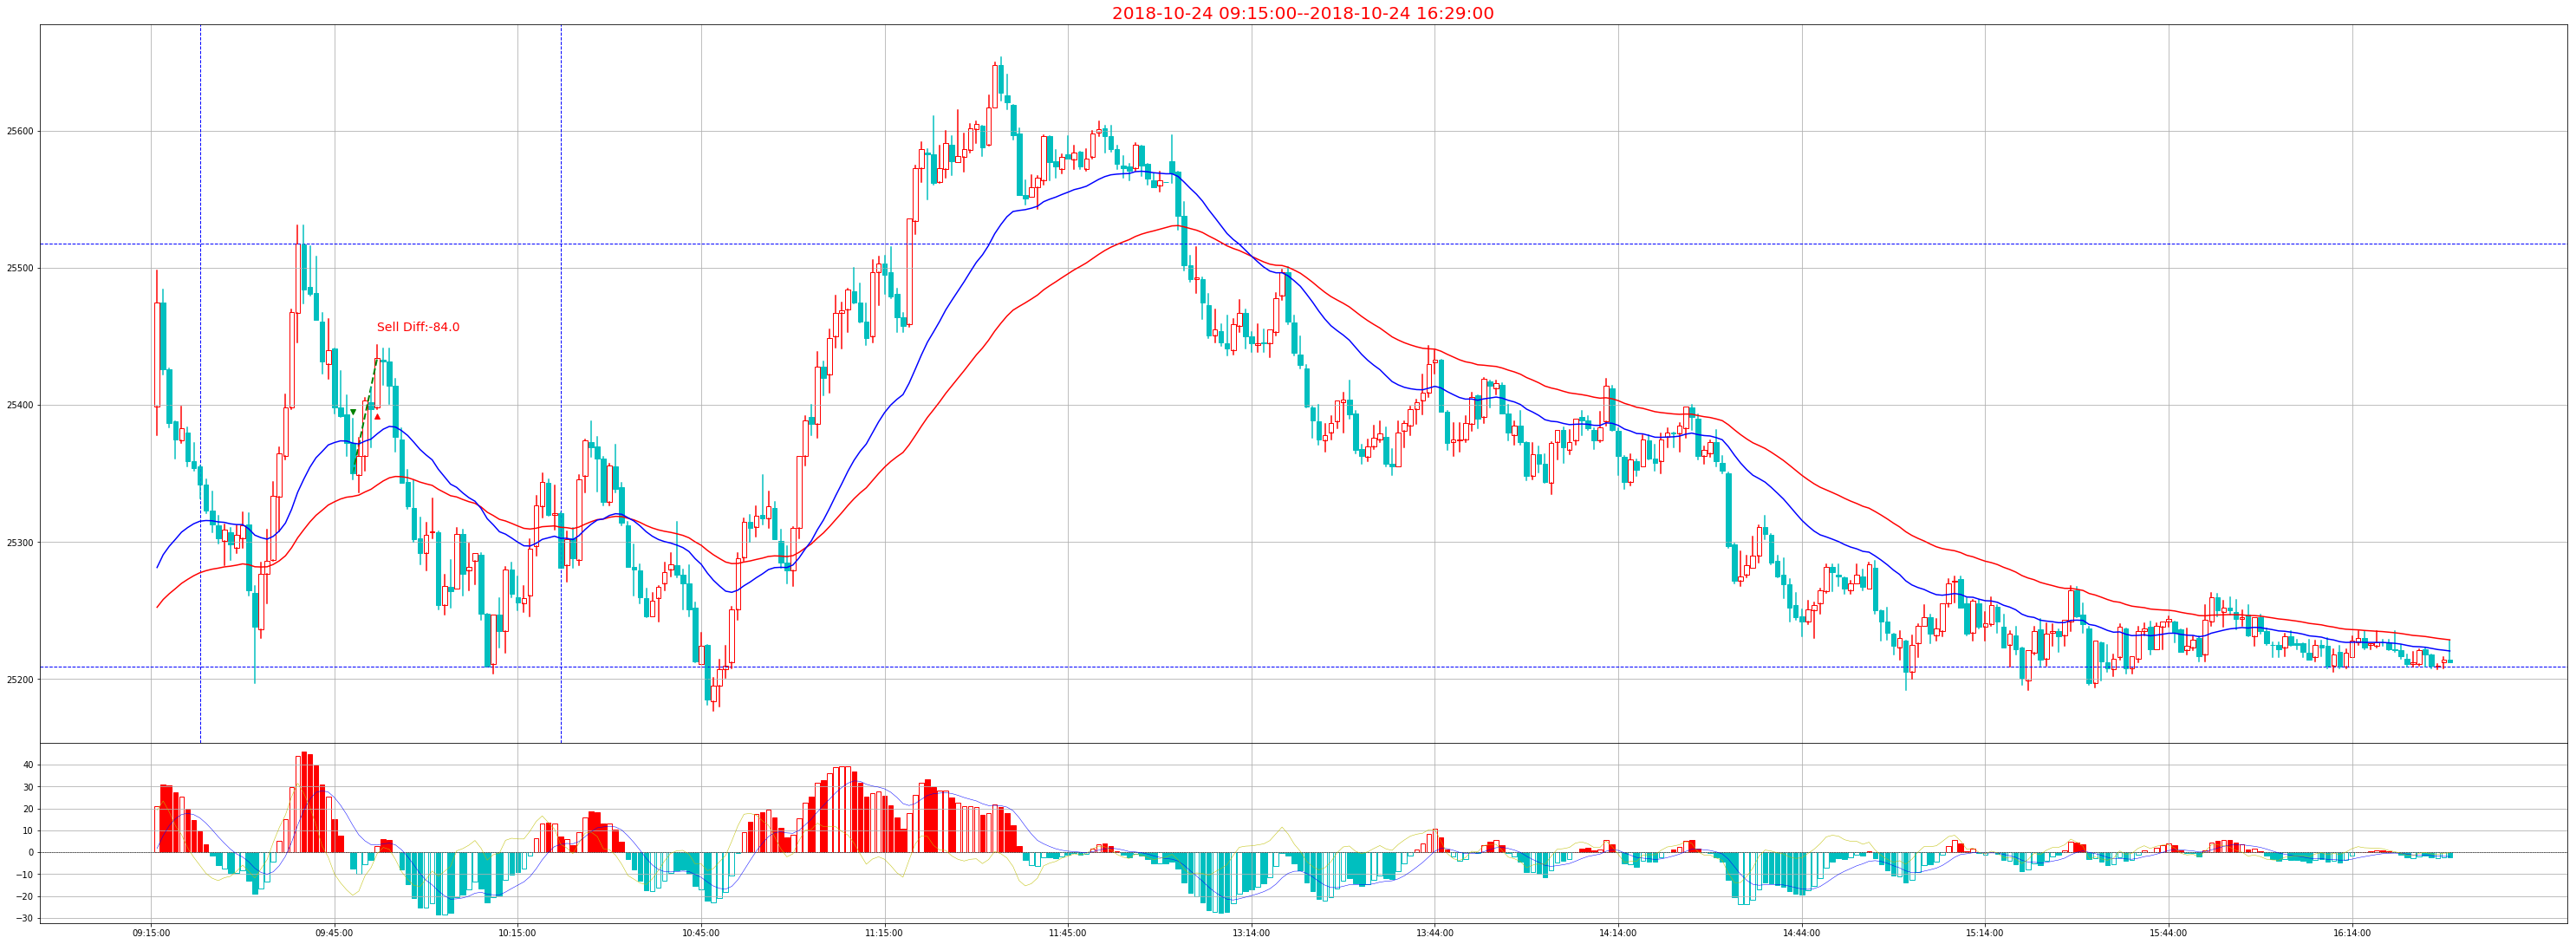

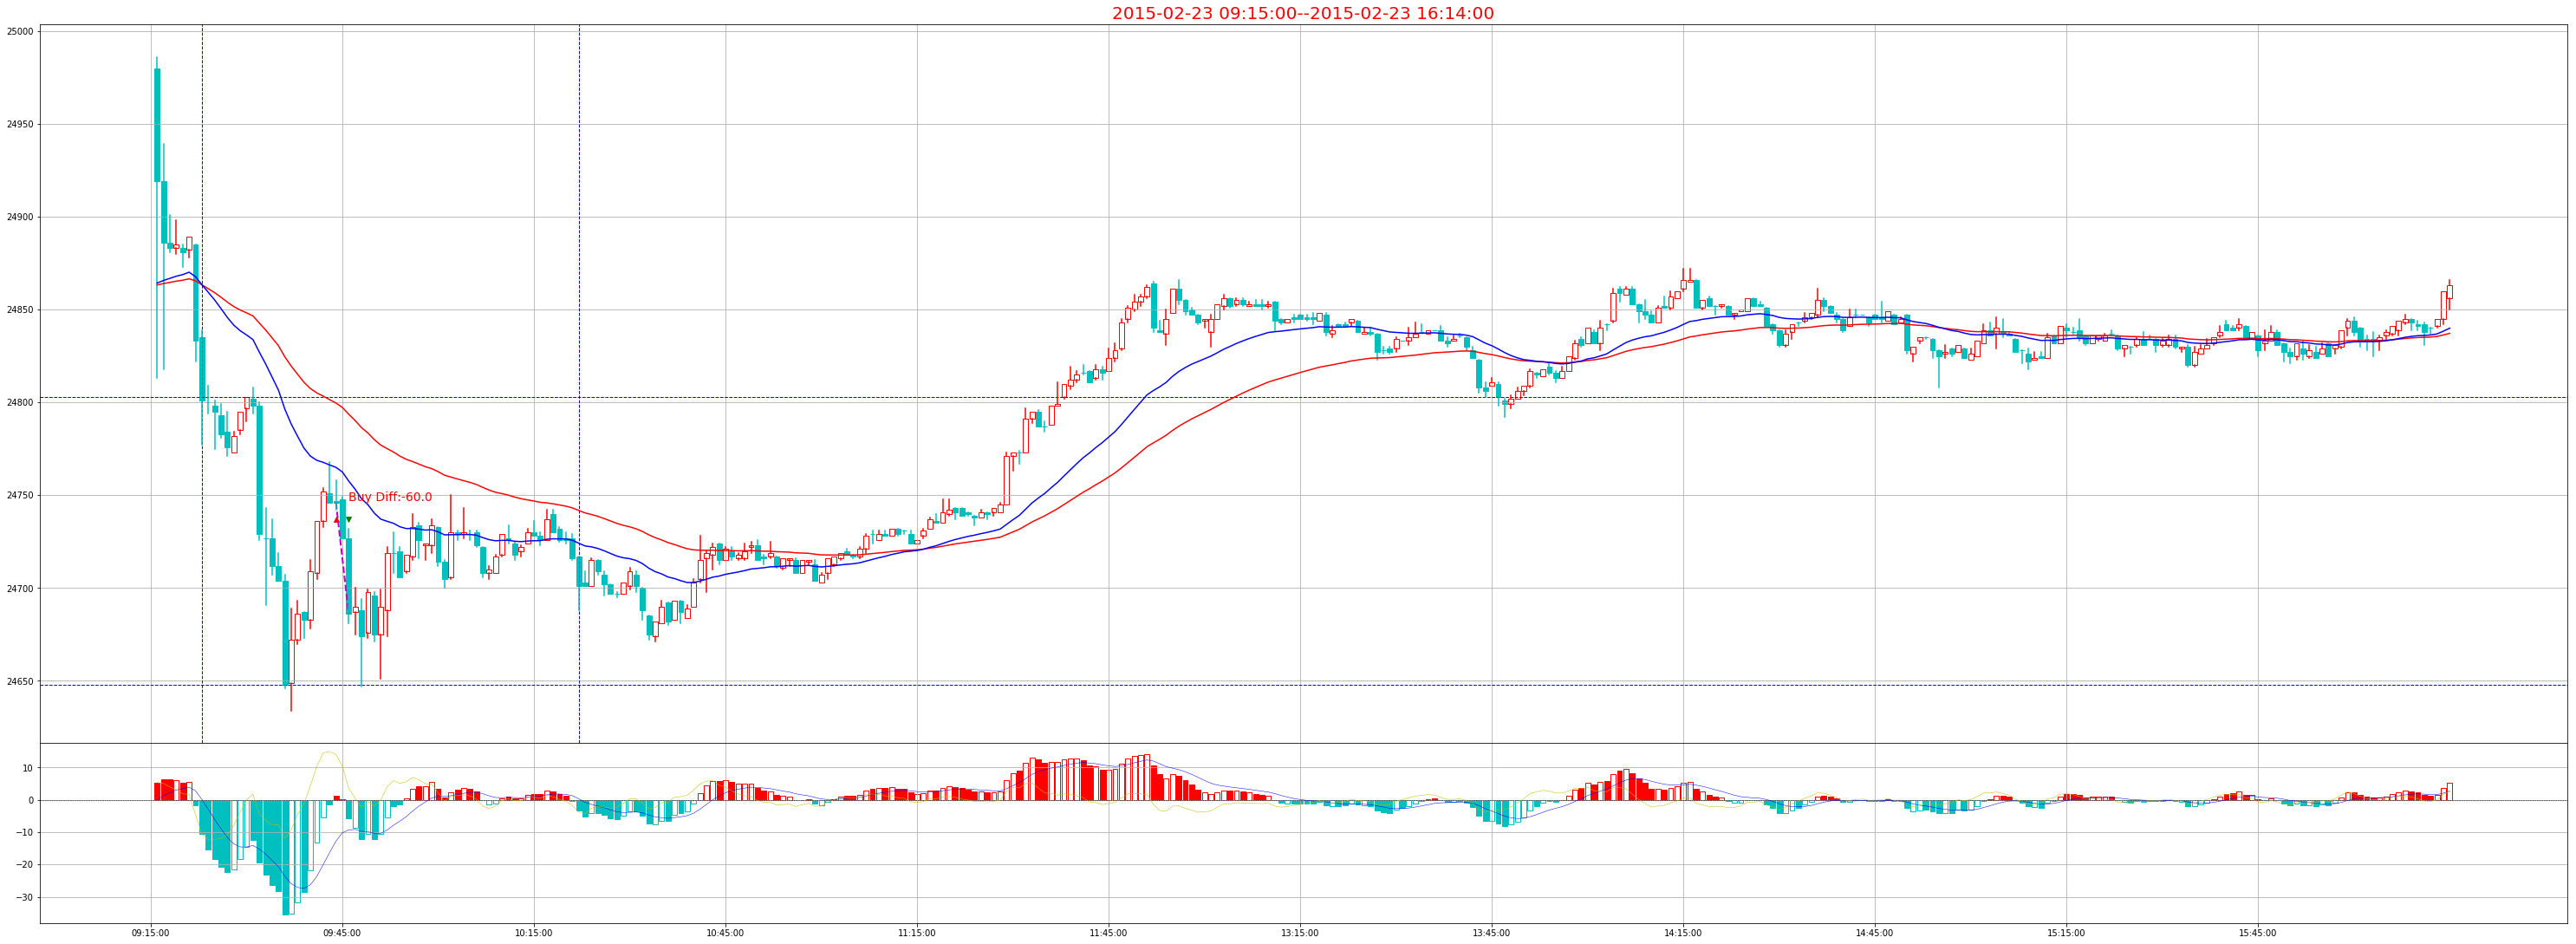

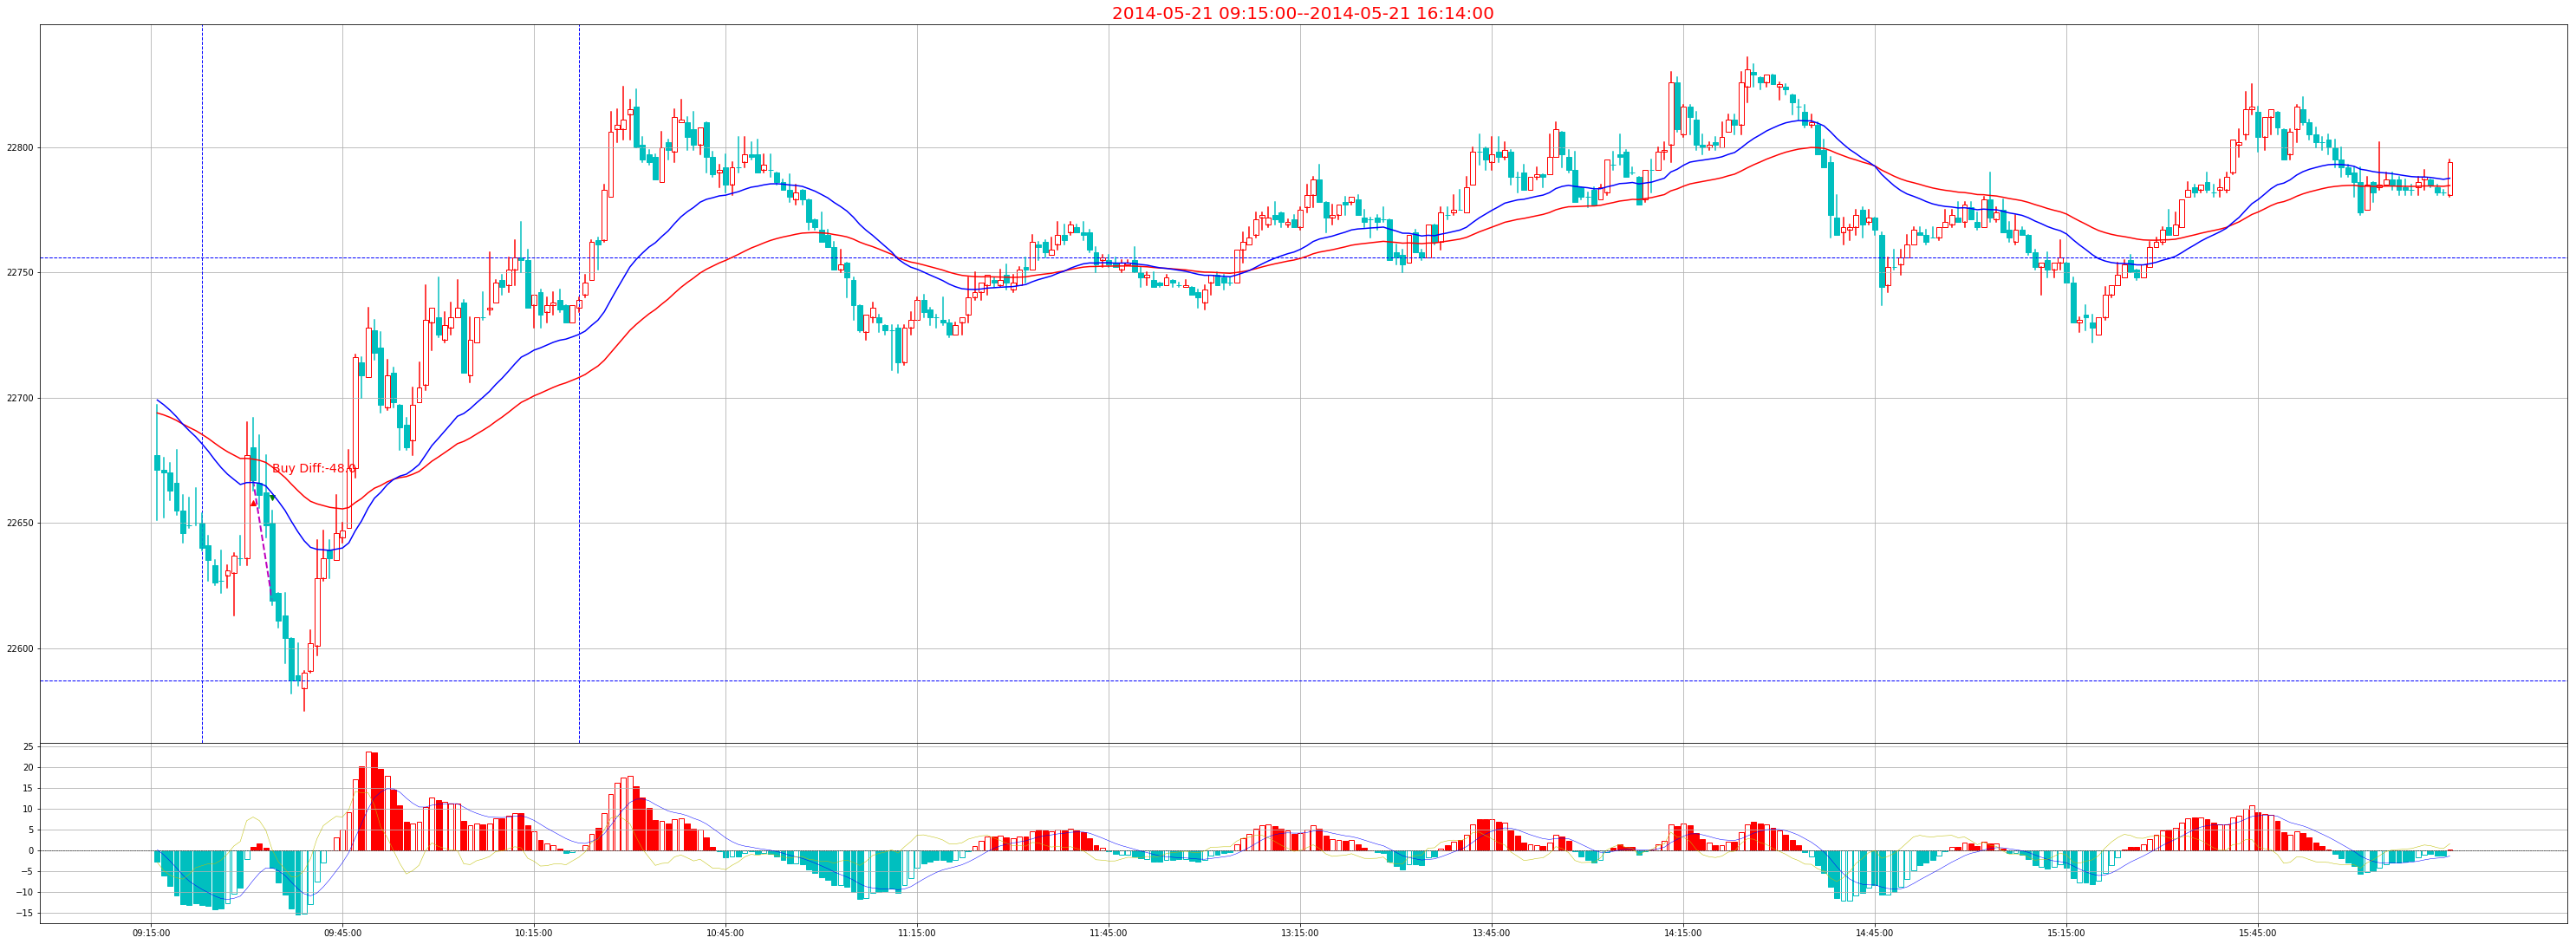

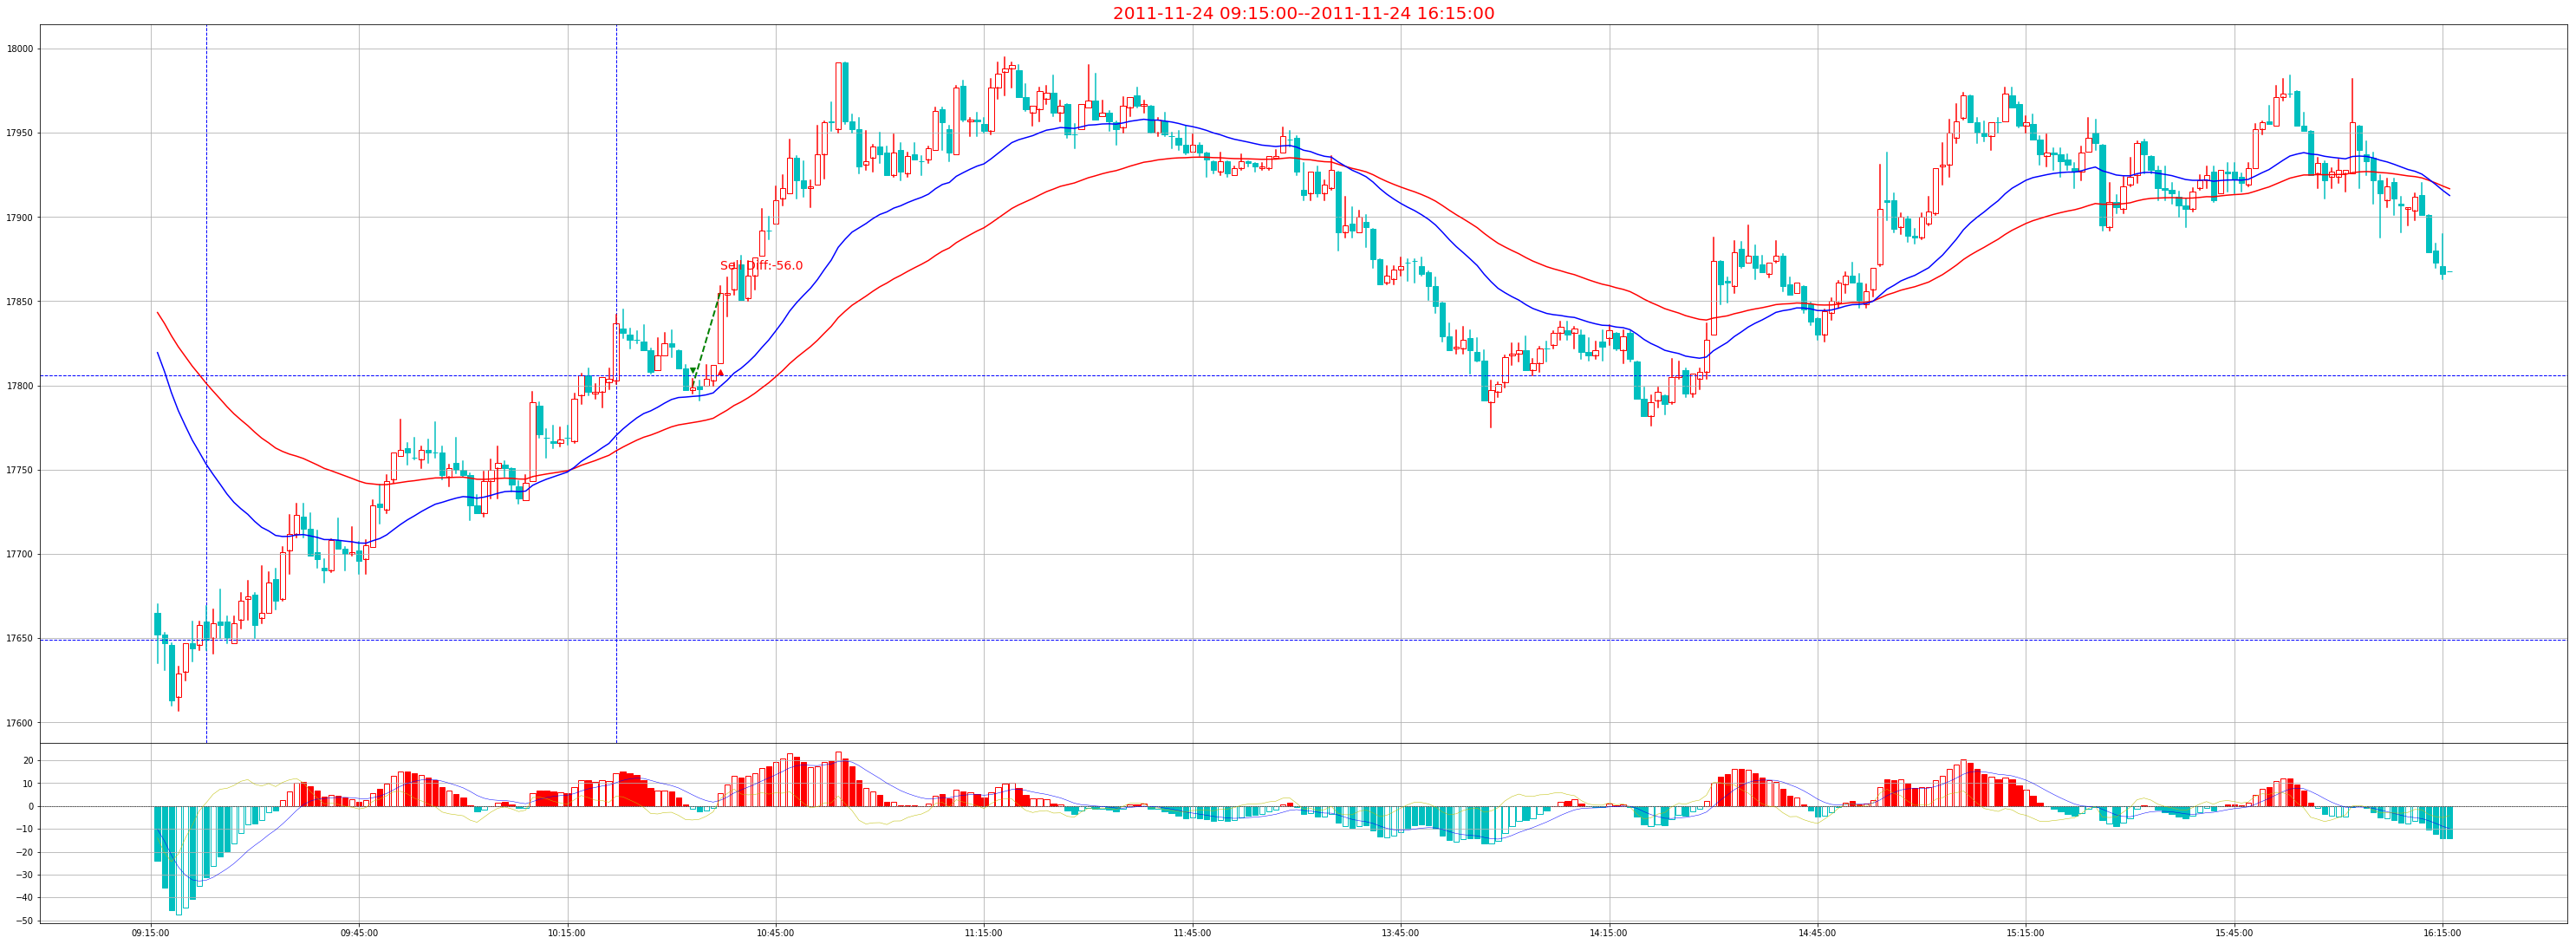

In [44]:
from kline import Kline
k=Kline()
# drawKK(k,'HSI1103','2011-02-28')
# cont=(macd.state=='red') &(macd.no==1) & (macd.ma60_state=='under')
df2=df1.sort_values('diff')
for i,row in df2.head(10).iterrows():
#     print(row['prod'],row['date'])
    file="img/macd_h10_%s"%(row['date'].date())
    idx1=int(row['open_idx'])
    idx2=int(row['close_idx'])
    drawKK(k,row['prod'],row['date'],trade=[row['state'],idx1,idx2])